This notebook explains the process of "cooking" a model, i.e. the iterative process of building a model exploiting human knowledge and the Shapley Values from SHAP.

The dataset used is extracted from the World Bank Open Data (https://data.worldbank.org/). We will build a model that will order the countries according to the GDP per capita. We will use the 80% of the countries as the training dataset, 10% of the countries as the validation dataset, and the remaining 10% of the countries as the test dataset.

The features we included in this dataset are:

* Population: The population of the country (total).
* Health: UHC (Universal health coverage) service coverage index
* GINI: Deviation from a perfectly equal distribution of the income in the country.
* Industry: Industry (including construction), value added (% of GDP)
* Inflation: Inflation, consumer prices (annual %)
* Children OoS: Children out of school (% of primary school age)
* Equality: Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)
* Pregnant Adolescents: Adolescent fertility rate (births per 1,000 women ages 15-19)

The differences between this work and the presented in the paper are the following:

* MAE vs. RMSE: This example will use the Mean Average Error as the Error instead of the Root Mean Square Error.
* MAE vs. NDCG: We will also use the MAE to metric how good is our model in comparison to the NDCG.
* The code from comparison.py is structured in a loop. We unloop this process to facilitate the explanation. 


In [3]:
import pandas
import numpy
from sklearn.metrics import mean_absolute_error


data_pre = pandas.read_excel(open("Data_Extract_From_World_Development_Indicators.xlsx",'rb'),sheet_name="Data")
data = pandas.DataFrame(columns=['Population','Health',"GINI",'Industry','Children OoS','Inflation','Equality', 'Pregnant Adolescents','GDP per capita'])
countries = set(data_pre["Country Name"].tolist())
data_pre =data_pre.replace('..',numpy.NaN)

for country in countries:
    data = data.append(pandas.Series(name = country))
    data.at[country,'Population'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Population, total')]['2015 [YR2015]'].values[0]
    data.at[country,'Health'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='UHC service coverage index')]['2015 [YR2015]'].values[0]
    data.at[country,'GINI'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='GINI index (World Bank estimate)')]['2015 [YR2015]'].values[0]
    data.at[country,'Industry'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Industry (including construction), value added (% of GDP)')]['2015 [YR2015]'].values[0]
    data.at[country,'Children OoS'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Children out of school (% of primary school age)')]['2015 [YR2015]'].values[0]
    data.at[country,'Inflation'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Inflation, consumer prices (annual %)')]['2015 [YR2015]'].values[0]
    data.at[country,'Equality'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)')]['2015 [YR2015]'].values[0]
    data.at[country,'Pregnant Adolescents'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='Adolescent fertility rate (births per 1,000 women ages 15-19)')]['2015 [YR2015]'].values[0]
    data.at[country,'GDP per capita'] = data_pre.loc[(data_pre['Country Name']==country) & (data_pre['Series Name']=='GDP per capita (current US$)')]['2015 [YR2015]'].values[0]

data = data.dropna(subset=['GDP per capita'])
    
from sklearn.model_selection import train_test_split

train, validationTest = train_test_split(data, test_size=0.2)
validation, test = train_test_split(validationTest, test_size=0.5)

trainY = train['GDP per capita'].astype('float32')
validationY = validation['GDP per capita'].astype('float32')
testY = test['GDP per capita'].astype('float32')
trainX = train.drop(['GDP per capita'], axis=1).astype('float32')
validationX = validation.drop(['GDP per capita'], axis=1).astype('float32')
testX = test.drop(['GDP per capita'], axis=1).astype('float32')
      
data.loc['Paraguay']

Population              6.68875e+06
Health                           68
GINI                           47.6
Industry                    34.6276
Children OoS                    NaN
Inflation                     3.129
Equality                          1
Pregnant Adolescents        71.4732
GDP per capita               5406.7
Name: Paraguay, dtype: object

Now we have a training, validation and test dataset. We follow the same structure explained in the paper.

In [6]:
from sklearn.metrics import mean_absolute_error
import catboost as cbt

i_features = set()

trainValidationX = pandas.concat([trainX,validationX], ignore_index=False)
trainValidationY = pandas.concat([trainY,validationY], ignore_index=False)

previous_model = cbt.CatBoostRegressor(loss_function='MAE',ignored_features = i_features,metric_period = 500,train_dir="./entrenament/",bootstrap_type = 'Bernoulli',subsample = 0.66,eval_metric = 'MAE',early_stopping_rounds = 500,iterations=100000,random_seed=99,use_best_model=True)
previous_model.fit(trainX,trainY,eval_set=(validationX,validationY))

model = cbt.CatBoostRegressor(loss_function='MAE',ignored_features = i_features,metric_period = 500,train_dir="./entrenament/",bootstrap_type = 'Bernoulli',subsample = 0.66,eval_metric = 'MAE',iterations=previous_model.best_iteration_,random_seed=99)
model.fit(trainValidationX,trainValidationY)

predictionTest = model.predict(testX)


0:	learn: 13840.5988481	test: 7984.0075458	best: 7984.0075458 (0)	total: 2.22ms	remaining: 3m 41s
500:	learn: 2745.0714448	test: 5164.9153859	best: 4580.7347457 (91)	total: 995ms	remaining: 3m 17s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 4580.734746
bestIteration = 91

Shrink model to first 92 iterations.
0:	learn: 13215.9068957	total: 2.12ms	remaining: 191ms
90:	learn: 5845.4598104	total: 206ms	remaining: 0us


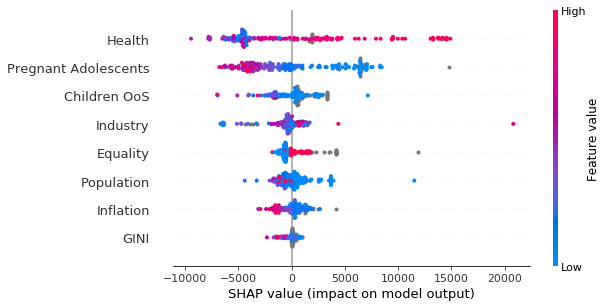

In [8]:
import shap
shap_values_train = model.get_feature_importance(cbt.Pool(trainValidationX,trainValidationY), type='ShapValues')
shap.summary_plot(numpy.array(shap_values_train[:,:-1]),features=numpy.array(trainValidationX),feature_names=trainValidationX.columns)

Small analysis:
    
We detect an outlier in Industry: a country with high industry with a shapley value much higher than the others. This country is Liechtenstein

In [9]:
pos = data.columns.get_loc('Industry')
maxPos = [val[pos] for val in shap_values_train]
maxPosIndex = maxPos.index(max(maxPos))
trainValidationX.iloc[maxPosIndex]

Population              37470.000000
Health                           NaN
GINI                             NaN
Industry                   37.260265
Children OoS                0.033490
Inflation                        NaN
Equality                         NaN
Pregnant Adolescents             NaN
Name: Liechtenstein, dtype: float32

Liechtenstein is unique: very small, very rich, with very few information. We might consider removing the instance in our training dataset to obtain a fairer model.

In [13]:
trainValidationX = trainValidationX.drop('Liechtenstein')
trainValidationY = trainValidationY.drop('Liechtenstein')
trainX = trainX.drop('Liechtenstein')
trainY = trainY.drop('Liechtenstein')

In [15]:
i_features_2 = set()


previous_model_2 = cbt.CatBoostRegressor(loss_function='MAE',ignored_features = i_features_2,metric_period = 500,train_dir="./entrenament/",bootstrap_type = 'Bernoulli',subsample = 0.66,eval_metric = 'MAE',early_stopping_rounds = 500,iterations=100000,random_seed=99,use_best_model=True)
previous_model_2.fit(trainX,trainY,eval_set=(validationX,validationY))

model_2 = cbt.CatBoostRegressor(loss_function='MAE',ignored_features = i_features,metric_period = 500,train_dir="./entrenament/",bootstrap_type = 'Bernoulli',subsample = 0.66,eval_metric = 'MAE',iterations=previous_model_2.best_iteration_,random_seed=99)
model_2.fit(trainValidationX,trainValidationY)

predictionTest_2 = model_2.predict(testX)

0:	learn: 13113.2797442	test: 7970.5098851	best: 7970.5098851 (0)	total: 985us	remaining: 1m 38s
500:	learn: 2577.9641735	test: 3963.2448170	best: 3962.8820116 (499)	total: 837ms	remaining: 2m 46s
1000:	learn: 1873.3035657	test: 3902.8883884	best: 3879.1939380 (971)	total: 1.69s	remaining: 2m 47s
1500:	learn: 1583.8032062	test: 3885.9941620	best: 3865.9757449 (1275)	total: 2.47s	remaining: 2m 42s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 3865.975745
bestIteration = 1275

Shrink model to first 1276 iterations.
0:	learn: 12425.5022020	total: 2.63ms	remaining: 3.36s
500:	learn: 2616.1104466	total: 795ms	remaining: 1.23s
1000:	learn: 1881.6771681	total: 1.65s	remaining: 452ms
1274:	learn: 1687.7585698	total: 2.09s	remaining: 0us


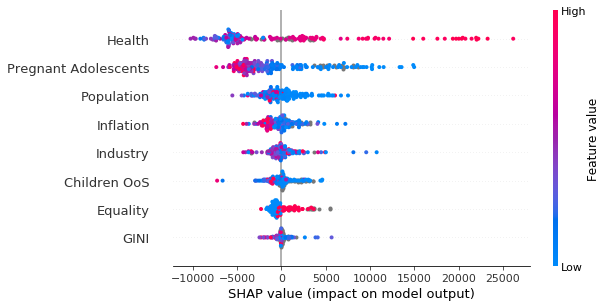

In [20]:
shap_values_train = model_2.get_feature_importance(cbt.Pool(trainValidationX,trainValidationY), type='ShapValues')
shap.summary_plot(numpy.array(shap_values_train[:,:-1]),features=numpy.array(trainValidationX),feature_names=trainValidationX.columns)

The GINI index is the least significant variable according to the Shapley Values. We decide to remove the feature.

In [21]:

pos = data.columns.get_loc('GINI')
i_features_3  = set()
i_features.add(pos)


previous_model_3 = cbt.CatBoostRegressor(loss_function='MAE',ignored_features = i_features_3,metric_period = 500,train_dir="./entrenament/",bootstrap_type = 'Bernoulli',subsample = 0.66,eval_metric = 'MAE',early_stopping_rounds = 500,iterations=100000,random_seed=99,use_best_model=True)
previous_model_3.fit(trainX,trainY,eval_set=(validationX,validationY))

model_3 = cbt.CatBoostRegressor(loss_function='MAE',ignored_features = i_features,metric_period = 500,train_dir="./entrenament/",bootstrap_type = 'Bernoulli',subsample = 0.66,eval_metric = 'MAE',iterations=previous_model_3.best_iteration_,random_seed=99)
model_3.fit(trainValidationX,trainValidationY)

predictionTest_3 = model_3.predict(testX)

0:	learn: 13113.2797442	test: 7970.5098851	best: 7970.5098851 (0)	total: 1.04ms	remaining: 1m 44s
500:	learn: 2577.9641735	test: 3963.2448170	best: 3962.8820116 (499)	total: 876ms	remaining: 2m 53s
1000:	learn: 1873.3035657	test: 3902.8883884	best: 3879.1939380 (971)	total: 1.86s	remaining: 3m 3s
1500:	learn: 1583.8032062	test: 3885.9941620	best: 3865.9757449 (1275)	total: 2.8s	remaining: 3m 3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 3865.975745
bestIteration = 1275

Shrink model to first 1276 iterations.
0:	learn: 12440.1344201	total: 2.07ms	remaining: 2.64s
500:	learn: 2595.2063420	total: 814ms	remaining: 1.26s
1000:	learn: 1815.6742072	total: 1.67s	remaining: 458ms
1274:	learn: 1623.8632563	total: 2.11s	remaining: 0us


In [23]:
mean_absolute_error(testY,predictionTest_3)

8387.8734900723

In [24]:
mean_absolute_error(testY,predictionTest)

9974.063316197282

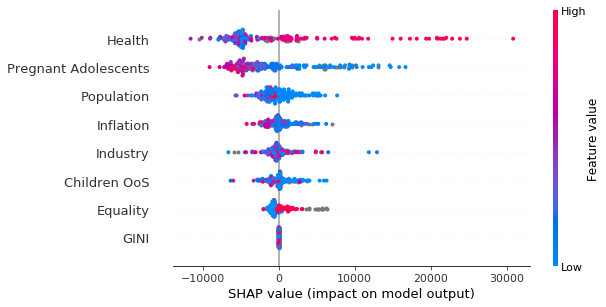

In [25]:
shap_values_train = model_3.get_feature_importance(cbt.Pool(trainValidationX,trainValidationY), type='ShapValues')
shap.summary_plot(numpy.array(shap_values_train[:,:-1]),features=numpy.array(trainValidationX),feature_names=trainValidationX.columns)

This is a small example of the process of cooking a model. In this case, we have just removed one country, and one feature, decreasing the Mean Absolute Error from 9974 to 8387. This control to the human specialist during the learning process facilitates its interaction with the model.